#### Simulate the asymptotic variance of different identification strategies

In [11]:
import sys
import random
import time
import pandas as pd
import numpy as np
import networkx as nx
from networkx import algorithms
from networkx.utils import groups

from itertools import chain, combinations
from collections import deque 
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import FancyBboxPatch
import seaborn as sns
from scipy import stats

from typing import List, Set, Dict, Optional, Union

from linearmodels.iv import IVGMM
import scipy.linalg as slg
import statsmodels.api as sm

import warnings
import inspect
import re

sys.path.append("../src")

from identification_strategy_finder import NIVStrategyFinder

#### Helpers for the experiment and the plotting

In [9]:
def calculate_sandwich_covariance(X: np.ndarray, residuals: np.ndarray, I: np.ndarray, W: np.ndarray) -> np.ndarray:
    """
    Calculate the sandwich covariance matrix, which provides a robust estimate of the variance-covariance matrix 
    of the coefficient estimates in a regression model.
    
    Args:
    - X: numpy array of shape (n_samples, n_features) representing the design matrix.
    - residuals: numpy array of residuals from the regression model.
    - I: numpy array representing the instrument matrix.
    - W: numpy array representing the weight matrix.
    
    Returns:
    - sandwich_cov: numpy array of the sandwich covariance matrix.
    """
    n, k = X.shape
    
    Q_XI = np.dot(X.T, I) / n
    Omega = np.zeros((I.shape[1], I.shape[1]))
    for i in range(n):
        Ii = I[i, :].reshape(-1, 1)
        Omega += np.dot(Ii, Ii.T) * (residuals[i] ** 2)
    Omega /= n
    
    Q_XI_W_Q_XI_T_inv = np.linalg.inv(np.dot(np.dot(Q_XI, W), Q_XI.T))
    filling = np.dot(np.dot(Q_XI, W), np.dot(Omega, np.dot(W, Q_XI.T)))
    
    sandwich_cov = np.dot(Q_XI_W_Q_XI_T_inv, np.dot(filling, Q_XI_W_Q_XI_T_inv)) / n
    return sandwich_cov

def estimate_results(X, Y, G, n_samples, type_effect, hidden_nodes, one_suffices):
    """
    Estimate the causal effects using the identified sets of instruments, nuisance, and conditioning sets.
    
    Args:
    - X: Set of treatment variables.
    - Y: Outcome variable.
    - G: Directed graph representing the causal structure.
    - n_samples: Number of samples for simulation.
    - type_effect: Type of effect to estimate ('direct' or 'total').
    - hidden_nodes: Set of hidden nodes in the graph.
    - one_suffices: Boolean indicating whether one valid adjustment set suffices.
    
    Returns:
    - results_dict: Dictionary containing the estimated coefficients and their corresponding standard errors.
    - coefficients: Dictionary containing the true coefficients used in the simulation.
    - best_results: Dictionary containing the best results based on the minimum standard error.
    """
    results_dict = {}
    data, coefficients = simulate_linear_SCM(G, n_samples)
    
    finder = NIVStrategyFinder(G, X, Y, hidden_nodes, type_effect, one_suffices)
    adjustment_sets = finder.find_adjustment_sets_nuisance()

    for i, item in enumerate(adjustment_sets):
        I = list(item["Instrument Set"]) if item["Instrument Set"] else None
        B = list(item["Conditional Set"]) if item["Conditional Set"] else None
        if item["Nuisance Set"]:
            N = list(item["Nuisance Set"])
        else:
            N = None
    
        N_data = np.array(data.loc[:, N]) if N is not None else None
        B_data = np.array(data.loc[:, B]) if B is not None else None
        I_data = np.array(data.loc[:, I]) if I is not None else None
        
        X_data = np.array(data.loc[:, list(X)])
        Y_data = np.array(data.loc[:, Y])
        
        result = civ(Y=Y_data, X=X_data, N=N_data, B=B_data, I=I_data)
        
        result_key = f"N:{N}, B:{B}, I:{I}"
        results_dict[result_key] = {
            "coefficients": result,
            "adjustment_set": result_key
        }
        
        if N_data is not None:
            XN_data = np.hstack((X_data, N_data))
        else:
            XN_data = X_data
        
        residuals = Y_data.copy()
        for j in range(XN_data.shape[1]):
            residuals -= result[j] * XN_data[:, j]
            
        I_dim = I_data.shape[1]
        
        sandwich_cov = calculate_sandwich_covariance(XN_data, residuals, I_data, W=np.eye(I_dim))
        standard_errors = np.sqrt(np.diag(sandwich_cov))
        
        results_dict[result_key]["standard_errors"] = standard_errors

    if type_effect == "total":
        total_causal_effect = 0
        for node_x in X: 
            causal_paths_from_x_to_Y = list(nx.all_simple_paths(G, node_x, Y))
            for path in causal_paths_from_x_to_Y:
                path_coefficients = 1 

                for i in range(len(path) - 1):
                    edge = (path[i], path[i+1])
                    edge_coefficient = coefficients[edge[1]][edge[0]] 
                    path_coefficients *= edge_coefficient    
                total_causal_effect += path_coefficients
            
    best_results = {}
    for i in range(len(list(X))):
        min_se = float("inf")
        best_key = None
        for key, value in results_dict.items():
            if value["standard_errors"][i] < min_se:
                min_se = value["standard_errors"][i]
                best_key = key
        if best_key:
            best_results[f"Best result for X_{i+1}"] = {
                "coefficient": results_dict[best_key]["coefficients"][i],
                "standard_error": results_dict[best_key]["standard_errors"][i],
                "adjustment_set": results_dict[best_key]["adjustment_set"]
            }
        
    for key, value in results_dict.items():
        print(f"Adjustment Set: {key}")
        if type_effect == "direct":
            print(f"Population Coefficients: {coefficients[Y][list(X)[0]]}")
            
        elif type_effect == "total":
            print(f"Population Coefficients: {total_causal_effect}")
            
        else:
            raise ValueError("Invalid type_effect: must either be direct or total")

        if "N:None" not in key:
            n_number = key.split(":")[1].split(",")[0].strip("[]")
            if n_number != "None":
                if n_number.isdigit():
                    n_column = int(n_number)
                else:
                    n_column = n_number.strip("'") 
                    
                if n_column in coefficients[Y]:
                    print(f"Nuisance Population Coefficients: {coefficients[Y][n_column]}")
                else:
                    print(f"Nuisance Population Coefficients: Column '{n_column}' has no direct effect on Y")
                
        for i, coef in enumerate(value["coefficients"].flatten()):
            print(f"Coefficient {i+1}: {coef}")
            print(f"Standard Error {i+1}: {value['standard_errors'][i]}")
        print()
        
    if not results_dict:
        print("The effect is not identifiable, I am sorry!")

    return results_dict, coefficients, best_results

def replace_variables(variables):
    """
    Helper function to replace numeric variables with their corresponding LaTeX variable names.
    
    Args:
    - variables: List of variables to replace.
    
    Returns:
    - List of variables with replacements applied.
    """
    return [replacement_map.get(var, var) for var in variables]

def transform_strategy(strategy):
    """
    Transform a strategy string into a more readable LaTeX-formatted string.
    
    Args:
    - strategy: The strategy string to transform.
    
    Returns:
    - civ: LaTeX-formatted string representing the strategy.
    """
    n_match = re.search(r"N:(\[[^\]]*\]|None)", strategy)
    b_match = re.search(r"B:\[([^\]]*)\]", strategy)
    i_match = re.search(r"I:\[([^\]]*)\]", strategy)
    
    N = n_match.group(1) if n_match else "None"
    if N != "None":
        N = replace_variables(N.strip("[]").split(", ")) if N.strip("[]") else []
    else:
        N = []
    
    B = replace_variables(b_match.group(1).split(", ")) if b_match and b_match.group(1) else []
    I = replace_variables(i_match.group(1).split(", ")) if i_match and i_match.group(1) else []
    if not B:
        B.append(r"\emptyset")
    if N:
        civ = r"$\operatorname{CIV}(" + ", ".join(I) + r" \mid X, " + ", ".join(N) + r" \rightarrow Y \mid " + ", ".join(B) + r")$"
    else:
        civ = r"$\operatorname{CIV}(" + ", ".join(I) + r" \mid X \rightarrow Y \mid " + ", ".join(B) + r")$"
    
    return civ

def format_number(num):
    """
    Format numbers by adding apostrophes for readability.
    
    Args:
    - num: The number to format.
    
    Returns:
    - Formatted number as a string.
    """
    return f"{int(num):,}".replace(",", "'")

def scientific_formatter(x, pos):
    """
    Custom formatter for scientific notation with LaTeX.
    
    Args:
    - x: The value to format.
    - pos: The position (required by matplotlib's formatter).
    
    Returns:
    - Formatted string for use in plots.
    """
    if x == 0:
        return "0"
    exponent = int(np.floor(np.log10(np.abs(x))))
    mantissa = x / 10**exponent
    return r"${:.1f} \times 10^{{{}}}$".format(mantissa, exponent)

#### Run the experiment for the specified graph
Can easily be parallelized if desired.

In [ ]:
G = nx.DiGraph()
G.add_edges_from([(1,2), (2,3), (4,2), (4,3), (4,5), (5,3),
                  (6,1), (6,5), (6,2), (7,1), (8,3)])
pos = {
    1: (0,0),
    2: (1,0),
    3: (2,0),
    4: (1.5,1),
    5: (1,-0.5),
    6: (0,-0.5),
    7: (0,1),
    8: (2,1)
}
nx.draw(G, pos = pos, with_labels = True)
X = {2}
Y = 3
hidden_nodes = {4}

sample_sizes = [20, 50, 200, 1000, 10000, 50000, 200000]
num_seeds = 200

coefficients = []
standard_errors = []
keys = []
observations = []
population_coefficients = []

for seed in range(num_seeds):
    np.random.seed(seed)  
    for n in sample_sizes:
        res, coefs, best = estimate_results(X=X, Y=Y, G=G, n_samples=n,
                                            type_effect="total",
                                            hidden_nodes=hidden_nodes,
                                            one_suffices=False)
        for key, value in res.items():
            keys.append(key)
            coefficients.append(value["coefficients"][0][0])
            standard_errors.append(value["standard_errors"][0])
            observations.append(n)
            population_coefficients.append(coefs[3][2])
            
results_df = pd.DataFrame({
    "strategy": keys,
    "coefficient": coefficients,
    "standard_error": standard_errors,
    "n_samples": observations,
    "population_coefficient": population_coefficients})

results_df.to_pickle("./results/asymptotic_variance_data.pkl")

#### Process the data for plotting

In [16]:
results_df = pd.read_pickle("./results/asymptotic_variance_data.pkl")

strategies_to_filter = [
    "N:[5], B:[1], I:[6, 7]",
    "N:[5], B:[8, 1], I:[6, 7]",
    "N:[5], B:None, I:[1, 7]",
    "N:[5], B:[6], I:[1, 7]",
    "N:[5], B:[8, 6], I:[1, 7]",
    "N:[5], B:[8], I:[1, 7]",
    "N:[8], B:[5, 6], I:[1, 7]",
    "N:[8], B:[6], I:[1, 7]",
    "N:[5, 8], B:None, I:[1, 6, 7]"
]  # they violate the rank condition; thus exclude them

results_df = results_df[~results_df["strategy"].isin(strategies_to_filter)]
average_se_df = results_df.groupby(["strategy", "n_samples"])["standard_error"].mean().reset_index()
results_df["coverage"] = results_df.apply(
    lambda row: 1 if (row["population_coefficient"] > row["coefficient"] - 1.96 * row["standard_error"] or row["population_coefficient"] < row["coefficient"] + 1.96 * row["standard_error"] < row["population_coefficient"]) else 0, axis=1)
average_coverage_df = results_df.groupby(["strategy", "n_samples"])["coverage"].mean().reset_index()

replacement_map = {
    "7": "V_1",
    "1": "V_2",
    "6": "V_3",
    "5": "V_4",
    "4": "H",
    "8": "V_5"
}

average_se_df["n_samples"] = average_se_df["n_samples"].apply(format_number)
average_coverage_df["n_samples"] = average_coverage_df["n_samples"].apply(format_number)

average_se_df["strategy"] = average_se_df["strategy"].apply(transform_strategy)
average_coverage_df["strategy"] = average_coverage_df["strategy"].apply(transform_strategy)

results_df_sorted = results_df.sort_values(by=["n_samples", "strategy"])
results_df_sorted["observation_index"] = results_df_sorted.groupby(["n_samples", "strategy"]).cumcount()
results_df_sorted["rank"] = results_df_sorted.groupby(["n_samples", "observation_index"])["standard_error"].rank(method="min")

#### Figure 6.1

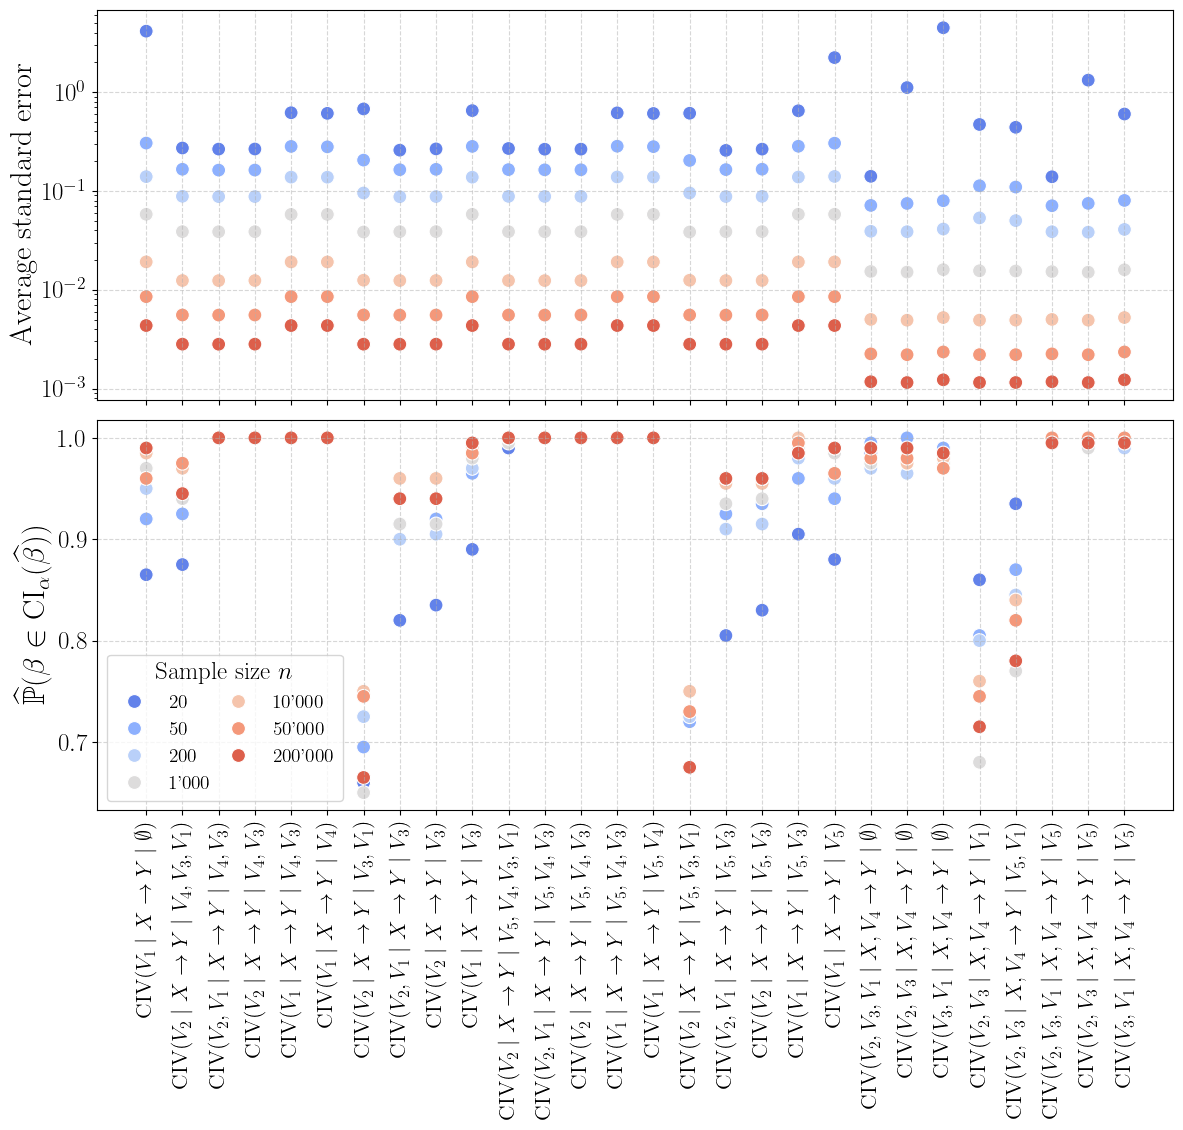

In [14]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
    "axes.labelsize": 22,     
    "xtick.labelsize": 16,    
    "ytick.labelsize": 18,    
    "legend.fontsize": 14,    
    "figure.titlesize": 22,   
    "axes.titlesize": 2,
    "legend.title_fontsize": 18
})

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

palette = sns.color_palette("coolwarm", len(average_se_df["n_samples"].unique()))
sns.scatterplot(
    data=average_se_df,
    x="strategy",
    y="standard_error",
    hue="n_samples",
    palette=palette,
    s=100,
    ax=ax1,
    legend = False
)

ax1.set_xlabel("")
ax1.set_ylabel("Average standard error")
ax1.set_yscale("log")
ax1.tick_params(labelbottom=False)  
ax1.grid(which="major", linestyle="--", alpha=0.5, zorder=-1.0)
plt.xticks(rotation=90, ha="center")

sns.scatterplot(
    data=average_coverage_df,
    x="strategy",
    y="coverage",
    hue="n_samples",
    palette=palette,
    s=100,
    ax=ax2
)

ax2.set_xlabel("")
ax2.set_ylabel(r"$\widehat{\mathbb{P}}(\beta \in \operatorname{CI}_{\alpha}(\widehat{\beta}))$")
ax2.legend(title="Sample size $n$", loc=3, ncol = 2, columnspacing = 0.3)
ax2.grid(which="major", linestyle="--", alpha=0.5, zorder=-1.0)
ax2.tick_params(labelbottom=True)  

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig("./plots/figure_6_1.svg", format="svg")
plt.show()

#### Figure 6.2

C:\Users\eminu\AppData\Local\Temp\ipykernel_25500\3956987514.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_data["n_samples"] = trimmed_data["n_samples"].apply(lambda x: f"{int(x):,}".replace(",", "'"))
C:\Users\eminu\AppData\Local\Temp\ipykernel_25500\3956987514.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


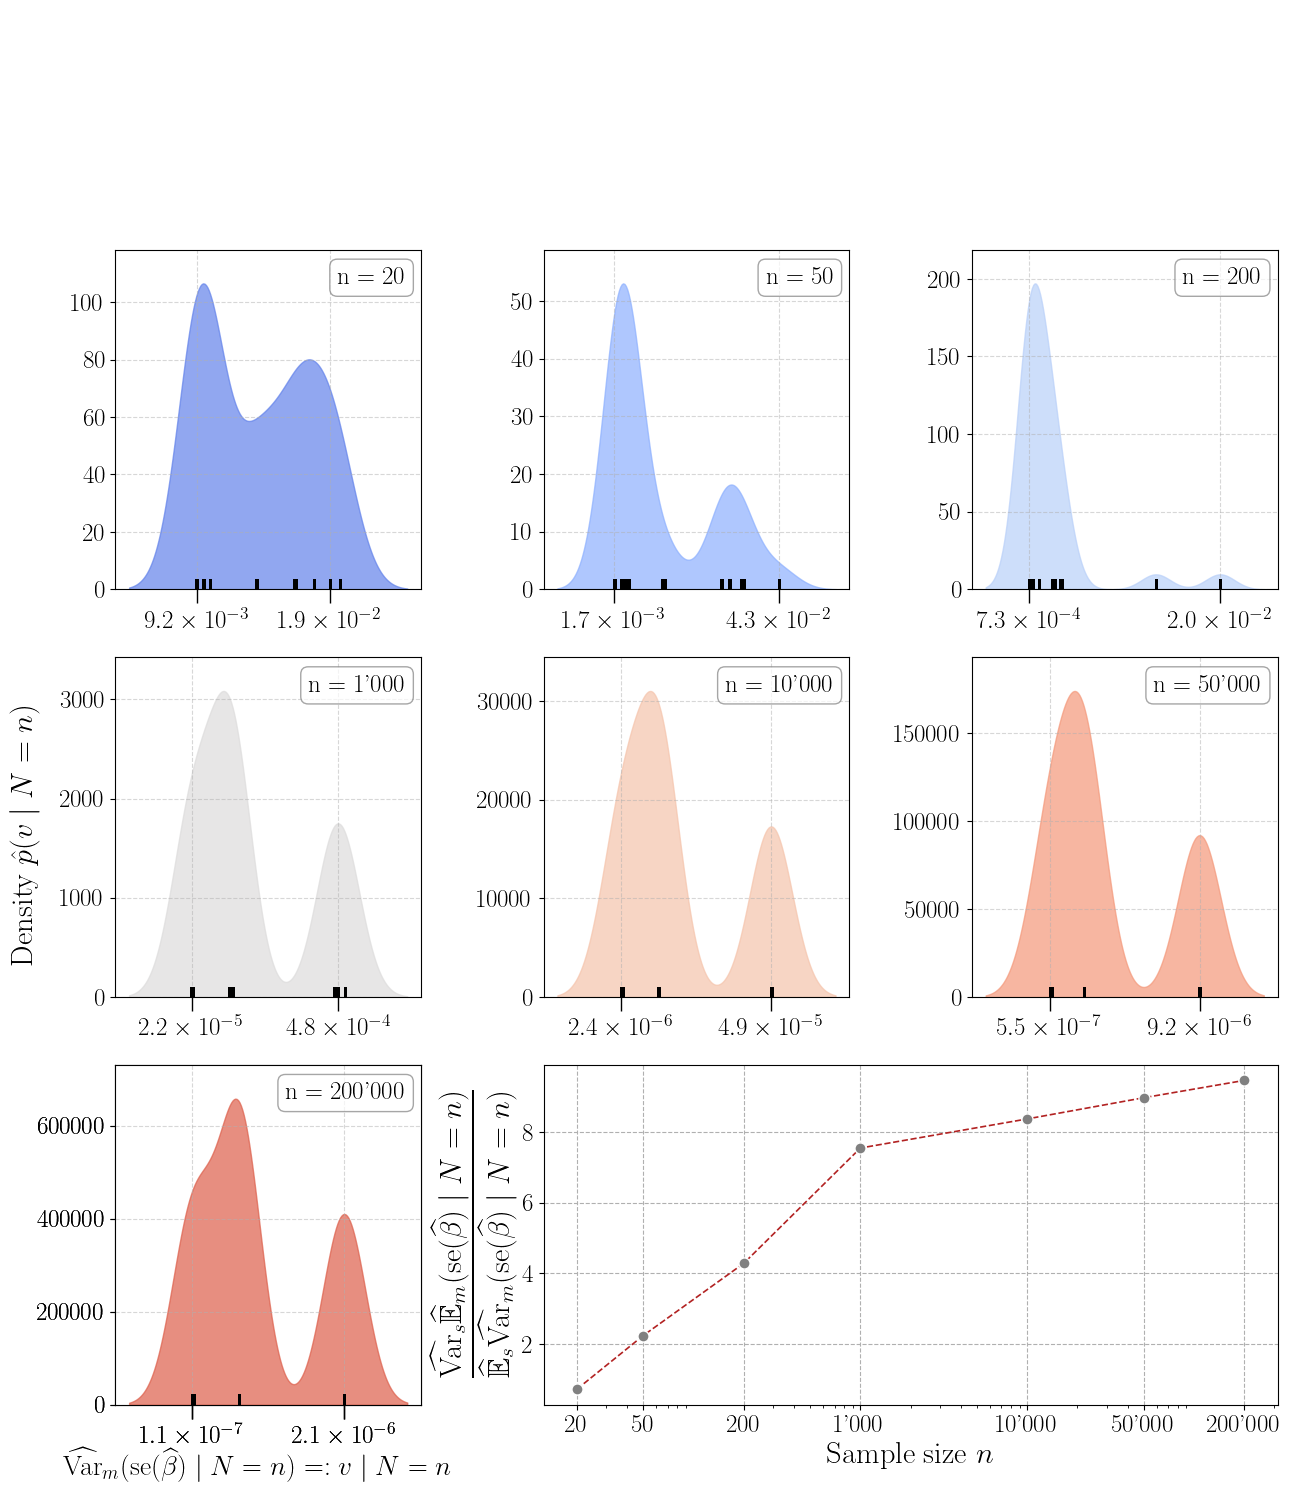

In [17]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
    "axes.labelsize": 22,     
    "xtick.labelsize": 18,  
    "ytick.labelsize": 18,    
    "legend.fontsize": 22,    
    "figure.titlesize": 22,   
    "axes.titlesize": 22,
    "legend.title_fontsize": 22
})

grouped = results_df.groupby(["strategy", "n_samples"])
results_df["within_variance"] = grouped["standard_error"].transform("var")

lower_bound = np.percentile(results_df["within_variance"], 0)
upper_bound = np.percentile(results_df["within_variance"], 90)

trimmed_data = results_df[(results_df["within_variance"] >= lower_bound) & (results_df["within_variance"] <= upper_bound)]
trimmed_data["n_samples"] = trimmed_data["n_samples"].apply(lambda x: f"{int(x):,}".replace(",", "'"))

sample_sizes = trimmed_data["n_samples"].unique()
palette = sns.color_palette("coolwarm", len(sample_sizes))

fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(3, 3, height_ratios=[1, 1, 1], hspace=0.2, wspace=0.4)

axes = [fig.add_subplot(gs[i // 3, i % 3]) for i in range(len(sample_sizes))]

for i, sample_size in enumerate(sample_sizes):
    data = trimmed_data[trimmed_data["n_samples"] == sample_size]
    sns.kdeplot(data["within_variance"], fill=True, color=palette[i], bw_adjust=2, ax=axes[i])
    sns.rugplot(data["within_variance"], color="black", height=0.03, ax=axes[i])
    
    axes[i].collections[0].set_alpha(0.7)
    axes[i].grid(True, which="major", linestyle="--", alpha=0.5)
    axes[i].xaxis.set_major_formatter(FuncFormatter(scientific_formatter))
    
    if i == 1 or i == 2:
        x_ticks = np.percentile(data["within_variance"], [3, 98])
    else:
        x_ticks = np.percentile(data["within_variance"], [10, 90])
    
    axes[i].set_xticks(x_ticks)
    axes[i].tick_params(axis="x", which="both", length=10, width=1)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
    axes[i].text(0.95, 0.95, f"n = {sample_size}", transform=axes[i].transAxes, 
                 ha="right", va="top", fontsize=18, bbox=dict(facecolor="white", alpha=0.7, edgecolor="grey", boxstyle="round,pad=0.3"))

last_kde_ax = fig.add_subplot(gs[2, 0])

last_sample_size = sample_sizes[-1]
data = trimmed_data[trimmed_data["n_samples"] == last_sample_size]
sns.kdeplot(data["within_variance"], fill=True, color=palette[-1], bw_adjust=2, ax=last_kde_ax)
sns.rugplot(data["within_variance"], color="black", height=0.03, ax=last_kde_ax)

last_kde_ax.collections[0].set_alpha(0.7)
last_kde_ax.grid(True, which="major", linestyle="--", alpha=0.5)
last_kde_ax.xaxis.set_major_formatter(FuncFormatter(scientific_formatter))
x_ticks = np.percentile(data["within_variance"], [10, 90])
last_kde_ax.set_xticks(x_ticks)
last_kde_ax.tick_params(axis="x", which="both", length=10, width=1)
last_kde_ax.set_xlabel("")
last_kde_ax.set_ylabel("")
last_kde_ax.text(0.95, 0.95, f"n = {last_sample_size}", transform=last_kde_ax.transAxes, 
                 ha="right", va="top", fontsize=18, bbox=dict(facecolor="white", alpha=0.7, edgecolor="grey", boxstyle="round,pad=0.3"))

wide_ax = fig.add_subplot(gs[2, 1:])

sample_sizes_sorted = []
variance_ratios = []

for sample_size in results_df_sorted["n_samples"].unique():
    data = results_df_sorted[results_df_sorted["n_samples"] == sample_size]
    within_variance_mean = data.groupby("strategy")["rank"].var().mean()
    strategy_means = data.groupby("strategy")["rank"].mean()
    between_variance = np.var(strategy_means)
    variance_ratio = between_variance / within_variance_mean
    sample_sizes_sorted.append(sample_size)
    variance_ratios.append(variance_ratio)

wide_ax.plot(sample_sizes_sorted, variance_ratios, marker="o", linestyle="--", color="firebrick", linewidth=1.2, 
             markerfacecolor="grey", markeredgecolor="white", markersize=8)

wide_ax.set_xscale("log")
wide_ax.set_xticks(sample_sizes_sorted)
wide_ax.set_xticklabels([f"{int(x):,}".replace(",", "'") for x in sample_sizes_sorted], fontsize=18, color="black")

wide_ax.set_xlabel("Sample size $n$")
wide_ax.set_ylabel(r"$\dfrac{\widehat{\operatorname{Var}}_s\widehat{\mathbb{E}}_m(\operatorname{se}(\widehat{\beta})\mid N = n)}{\widehat{\mathbb{E}}_s\widehat{\operatorname{Var}}_m(\operatorname{se}(\widehat{\beta})\mid N = n)}$")
wide_ax.grid(True, which="major", ls="--")

handles, labels = axes[0].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=len(sample_sizes))
for text in legend.get_texts():
    text.set_color("black")
fancy_box = FancyBboxPatch((0, 0), 1, 1, boxstyle="round,pad=0.3", edgecolor="grey", facecolor="white", mutation_aspect=1)
legend.get_frame().set_linewidth(0)
legend.get_frame().set_boxstyle(fancy_box.get_boxstyle())

fig.text(0.22, 0.07, r"$\widehat{\operatorname{Var}}_m(\operatorname{se}(\widehat{\beta}) \mid N=n)=:v\mid N = n$", ha="center", va="center", fontsize=20)
fig.text(0.065, 0.49, "Density $\hat{p}(v\mid N = n)$", ha="center", va="center", rotation="vertical", fontsize=22)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("./plots/figure_6_2.svg", format="svg")
plt.show()